In [1]:
from scipy.io import loadmat
data = loadmat('trainingData.mat')
data = data['dataRecord']


Epoch 1/100, Training Loss: 0.0462, Validation Loss: 0.0307
Epoch 2/100, Training Loss: 0.0219, Validation Loss: 0.0144
Epoch 3/100, Training Loss: 0.0100, Validation Loss: 0.0062
Epoch 4/100, Training Loss: 0.0041, Validation Loss: 0.0023
Epoch 5/100, Training Loss: 0.0014, Validation Loss: 0.0007
Epoch 6/100, Training Loss: 0.0004, Validation Loss: 0.0002
Epoch 7/100, Training Loss: 0.0001, Validation Loss: 0.0000
Epoch 8/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 9/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 10/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 11/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 12/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 13/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 14/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 15/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 16/100, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 17/100, Training Loss: 0.00

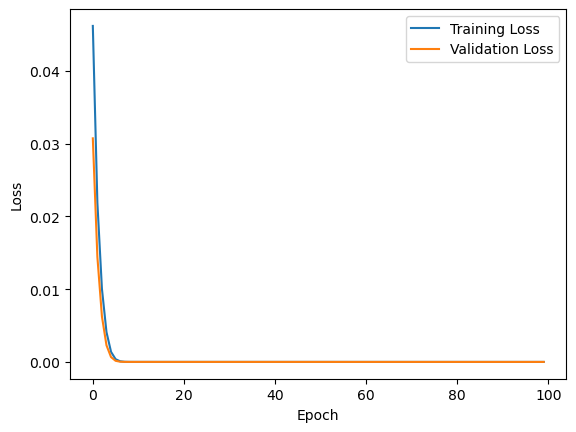

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# 假设你的数据是numpy数组形式，需要转换成torch Tensor
inputs = torch.tensor(data[:, :6], dtype=torch.float32)
outputs = torch.tensor(data[:, 6:], dtype=torch.float32)

# 创建数据集
dataset = TensorDataset(inputs, outputs)

# 划分训练集和验证集（例如：80%训练，20%验证）
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 创建数据加载器
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False)

test_size = [4,8,16,32]

for i in range(4):
    # 定义神经网络模型
    class SimpleFNN(nn.Module):
        def __init__(self):
            super(SimpleFNN, self).__init__()
            self.fc1 = nn.Linear(6, test_size[i])  # 输入层到隐藏层
            self.fc2 = nn.Linear(test_size[i], 3)  # 输出层

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            return self.fc2(x)

    model = SimpleFNN()
    model.train()

    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 训练网络
    epochs = 100
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)  # 累计每个batch的损失

        # 计算并存储平均训练损失
        avg_train_loss = running_train_loss / len(train_dataloader.dataset)
        train_losses.append(avg_train_loss)

        # 验证阶段
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():  # 禁用梯度计算
            for inputs, labels in val_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)  # 累计每个batch的损失

        # 计算并存储平均验证损失
        avg_val_loss = running_val_loss / len(val_dataloader.dataset)
        val_losses.append(avg_val_loss)

        # 输出当前epoch的训练和验证损失
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # 绘制训练和验证损失曲线
    import matplotlib.pyplot as plt

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [3]:
# infer and save
test_input = torch.tensor([[0.11412254, -0.09698317, -0.13648682, -0.08168529,  0.09584415,
        -0.08081015]], dtype=torch.float32)  # 示例输入数据
with torch.no_grad():
    prediction = model(test_input)
    print(f'Prediction: {prediction.numpy()}')
    print("-0.01443261, -0.01519005, -0.02687549")
# save the model
scripted_model = torch.jit.script(model)
torch.jit.save(scripted_model, '../model/model.pth')

Prediction: [[-0.01489132 -0.01550774 -0.02605757]]
-0.01443261, -0.01519005, -0.02687549


In [4]:
for name, param in model.named_parameters():
    # 保存权重
    np.savetxt(f"../model/{name}_weight.txt", param.data.cpu().numpy())

    # 检查是否存在偏置，并保存
    if hasattr(param, 'bias') and param.bias is not None:
        np.savetxt(f"./model/{name}_bias.txt", param.bias.data.cpu().numpy())

In [4]:
model.named_parameters()

<generator object Module.named_parameters at 0x321720d40>

In [71]:
data = loadmat('testingData.mat')
test_data = data['dataRecord']

# 测试数据集，应该与训练数据集具有相同的结构
test_inputs = torch.tensor(test_data[:, :6], dtype=torch.float32)
test_outputs = torch.tensor(test_data[:, 6:], dtype=torch.float32)

# 创建测试 DataLoader
test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=10)

# 将模型设置为评估模式
model.eval()

# 初始化损失计算
test_loss = 0.0
with torch.no_grad():  # 确保不进行梯度计算
    for inputs, labels in test_loader:
        # 前向传播
        outputs = model(inputs)
        # 计算损失
        loss = criterion(outputs, labels)
        test_loss += loss.item()

# 平均损失
test_loss /= len(test_loader)
print(f'Average loss on the test dataset: {test_loss}')


Average loss on the test dataset: 5.30677266397106e-07


In [72]:
qm = torch.quantization.quantize_dynamic(model, {nn.Linear,torch.relu}, dtype=torch.qint8)
qm.eval()

# 初始化损失计算
test_loss = 0.0
with torch.no_grad():  # 确保不进行梯度计算
    for inputs, labels in test_loader:
        # 前向传播
        outputs = qm(inputs)
        # 计算损失
        loss = criterion(outputs, labels)
        test_loss += loss.item()

# 平均损失
test_loss /= len(test_loader)
print(f'Average loss on the test dataset: {test_loss}')
scripted_qmodel = torch.jit.script(qm)
torch.jit.save(scripted_qmodel, '../model/qmodel.pth')

Average loss on the test dataset: 4.0735253321599884e-07
